## Counting experiment for all the processed MC

In [1]:
import numpy as np
import os
import pandas as pd
import tables as tb
from glob import glob

import matplotlib.pyplot as plt
import invisible_cities.io.dst_io as dio

from matplotlib.patches import Patch

From Gonzalo's thesis, he does a selection following the next cuts:

* **nexus**: picks the events that have a total energy inside the energy range
* **reco**: picks the events that have passed the reconstruction (I guess after Beersheba)
* **ene**: picks the events that have a total energy inside the energy range AFTER the reconstruction (due to energy corrections)
* **fid**: picks the events that have a R center of mass (hit transversal position weighted with energy) such as R < 45 cm (4cm from the chamber edges) and a Z center of mass of 2 < Z < 116 cm (2cm from the electrodes). It is correlated with the previous cut as the high radius events are corrected worse and have less energy than they should so are already removed.
* **track**: picks the events with 1 single reconstructed track (isaura)
* **ovl**: removes events where the track defined blobs have any bit of overlap

These are the analysis selections. For discrimination selections, we have two options:
* **ROI**: selects the events based on an optimal energy window where the f.o.m. is maximized, in Gonzalo's analysis is [2.456, 2.472] MeV 
* **topo**: selects the events based on the energy of the least energetic blob, in this case picks the events with an energy > 0.57 MeV

In [2]:
def remove_spurious_tracks(tracks, spurious_energy):
    sel_spurious = (tracks.energy < spurious_energy)
    spurious_energies = tracks.loc[sel_spurious].groupby('event').energy.sum().reset_index().rename(columns={'energy':'spurious_ene'})
    spurious_energies['trackID'] = 0
    
    tracks = tracks.merge(spurious_energies, on = ['event', 'trackID'], how = 'outer')
    tracks['spurious_ene'] = tracks['spurious_ene'].fillna(0)

    tracks['energy'] = tracks['energy'] + tracks['spurious_ene']
    tracks = tracks.loc[~sel_spurious].drop('spurious_ene', axis = 1)
    tracks = tracks.drop('numb_of_tracks', axis = 1).merge(tracks.groupby('event').trackID.nunique().reset_index().rename(columns={'trackID':'numb_of_tracks'}), on = 'event')
    return tracks

In [3]:
def sum_dif_lens(a, b):
    lena, lenb = len(a), len(b)
    diff = abs(lena - lenb)
    if lena > lenb:
        b = np.append(b, np.zeros(diff, dtype = int))
    elif lena < lenb:
        a = np.append(a, np.zeros(diff, dtype = int))
    else:
        pass
    return a + b

In [4]:
def count_experiment(nexus_df, 
                     isa_df,
                     ene_min = 0.8, 
                     ene_range = (2.4, 2.5), 
                     rmax = 450, 
                     zmin = 20, 
                     zmax = 1160, 
                     ntrack = 1, 
                     ovl = 0, 
                     ene_roi = (2.456, 2.472), 
                     eblob2 = 0.57):
        nexus, reco, ener, ener_roi, fid, fid_roi, track, track_roi, ovl, ovl_roi, roi, topo, topo_roi, topo_roi_full = 0,0,0,0,0,0,0,0,0,0,0,0,0,0

        #NEXUS
        nexus += len(nexus_df.event_id.unique())
        nexus_tot_ene = nexus_df.groupby('event_id').sum().reset_index()[['event_id', 'energy']]

        #RECO
        reco += len(isa_df.event.unique())

        #ENE
        # To create the reconstructed energy spectra
        isa_tot_ene = isa_df.groupby('event').sum().reset_index()[['event', 'energy']]
        isa_df_ = isa_df.merge(isa_tot_ene.rename(columns = {'energy':'tot_ener'}), on = ['event'])
        isa_df_ene = isa_df_[isa_df_.tot_ener > ene_min]
        ener += len(isa_df_ene.event.unique())

        isa_df_ene_roi = isa_df_[(isa_df_.tot_ener > ene_range[0]) & (isa_df_.tot_ener < ene_range[1])]
        ener_roi += len(isa_df_ene_roi.event.unique())

        #FID
        isa_df_fid = isa_df_ene[(isa_df_ene.r_max < rmax) & (isa_df_ene.z_min > zmin) & (isa_df_ene.z_max < zmax)]
        fid += len(isa_df_fid.event.unique())

        isa_df_fid_roi = isa_df_ene_roi[(isa_df_ene_roi.r_max < rmax) & (isa_df_ene_roi.z_min > zmin) & (isa_df_ene_roi.z_max < zmax)]
        fid_roi += len(isa_df_fid_roi.event.unique())   
        
        #After the fiducialization, we take a look to the energy spectra and to the track multiplicity (mainly to justify the cuts)
        isa_tot_ene_fid = isa_df_fid.groupby('event').sum().reset_index()[['event', 'energy']]
        isa_numtracks = isa_df_fid[['event', 'numb_of_tracks']].drop_duplicates().numb_of_tracks

        #TRACK
        isa_df_track = isa_df_fid[isa_df_fid.numb_of_tracks == ntrack]
        track += len(isa_df_track)

        isa_df_track_roi = isa_df_fid_roi[isa_df_fid_roi.numb_of_tracks == ntrack]
        track_roi += len(isa_df_track_roi)

        #OVL
        isa_df_ovl = isa_df_track[isa_df_track.ovlp_blob_energy == ovl]
        ovl += len(isa_df_ovl)

        isa_df_ovl_roi = isa_df_track_roi[isa_df_track_roi.ovlp_blob_energy == ovl]
        ovl_roi += len(isa_df_ovl_roi)

        # After track and ovl cuts, we pick the energy distribution of the second blob
        isa_eblob2 = isa_df_ovl[['event', 'eblob2']]

        #ROI
        isa_df_roi = isa_df_ovl[(isa_df_ovl.tot_ener > ene_roi[0]) & (isa_df_ovl.tot_ener < ene_roi[1])]
        roi += len(isa_df_roi)

        #TOPO
        isa_df_topo = isa_df_ovl[isa_df_ovl.eblob2 > eblob2]
        topo += len(isa_df_topo)

        isa_df_topo_roi = isa_df_ovl_roi[isa_df_ovl_roi.eblob2 > eblob2]
        topo_roi += len(isa_df_topo_roi)


        isa_df_topo_full = isa_df_roi[isa_df_roi.eblob2 > eblob2]
        topo_roi_full += len(isa_df_topo_full)

        counts = np.array([nexus, reco, ener, ener_roi, fid, fid_roi, track, track_roi, ovl, ovl_roi, roi, topo, topo_roi, topo_roi_full])
        return counts, nexus_tot_ene, isa_tot_ene, isa_tot_ene_fid, isa_numtracks, isa_eblob2

In [5]:
#df_values = []

# This script creates for an isotope a file per volume saving the info of the counting experiment, energy spectra (nexus, reco and reco
# after fiducialization), number of tracks and energy of the second blob for the main tracks

# isotope = '214Bi'
# base_dir = os.path.expandvars('$LUSTRE/NEXT100/data/full_prod/{}/prod/volumes/*/'.format(isotope))
# vol_paths = sorted(glob(base_dir))

# sort_files = lambda x: int(x.split('_')[-2])
# outname = 'tracks_info.h5'

# for vol_path in vol_paths:
#     vol = vol_path.split('/')[-2]
#     print(vol)
#     isaura_files = sorted(glob(vol_path + 'prod/isaura/*'), key=sort_files)
#     nexus_files = sorted(glob(vol_path + 'prod/nexus/*'), key=sort_files)

#     total_counts = np.zeros(14, dtype = int)
#     for isaura_file, nexus_file in zip(isaura_files, nexus_files):
#         nexus_df = dio.load_dst(nexus_file, 'MC', 'hits')
#         isa_df = remove_spurious_tracks(dio.load_dst(isaura_file, 'Tracking', 'Tracks'), 0.01)
#         counts, nexus_tot_ene, isa_tot_ene, isa_tot_ene_fid, isa_numtracks, isa_eblob2 = count_experiment(nexus_df, isa_df)
        
#         total_counts += counts
        
#         outpath= '/'.join(isaura_file.split('/')[:-3]) + '/'
#         isa_tot_ene.to_hdf(outpath + outname, 'RecoEner', append=True)
#         isa_tot_ene_fid.to_hdf(outpath + outname, 'RecoEnerFid', append=True)
#         isa_numtracks.to_hdf(outpath + outname, 'NumTracks', append=True)
#         isa_eblob2.to_hdf(outpath + outname, 'EneBlob2', append=True)
        
#     df_dct = {'vol': vol, 'nexus':total_counts[0], 'reco':total_counts[1], 'ener':total_counts[2], 
#                 'ener_roi':total_counts[3], 'fid':total_counts[4], 'fid_roi':total_counts[5], 'track':total_counts[6], 
#                 'track_roi':total_counts[7], 'ovl':total_counts[8], 'ovl_roi':total_counts[9], 'roi':total_counts[10], 
#                 'topo':total_counts[11], 'topo_roi':total_counts[12], 'topo_roi_full':total_counts[13]}
#     pd.DataFrame([df_dct]).to_hdf(outpath + outname, 'selection_rates', append = True, min_itemsize=20)


### LO Q PODRÍA HACER ES IR GUARDANDO POR VOLUMEN YA CON df.to_hdf() y con la opción append para q no me lo sobreescriba digo yo, y así 
### si se me para lo puedo recuperar, O SI NO, hacer un script de esto (pero igualmente me parece buena idea irlo guardando)


In [ ]:
#ntrack_counts, ntrack_bins = np.histogram(numtracks, range = (0, numtracks.max()), bins = numtracks.max())
#ntrack_hist = sum_dif_lens(ntrack_hist, ntrack_counts)

In [73]:
numtracks = isa_df[['event', 'numb_of_tracks']].drop_duplicates().numb_of_tracks
np.histogram(numtracks, range = (0, numtracks.max()), bins = len(numtracks.unique()) )

(array([  0, 868, 703, 330, 122,  37]), array([0., 1., 2., 3., 4., 5., 6.]))

In [7]:
fileout = base_dir[:-2] + 'bkg_rates_selection.h5'
# with tb.open_file(fileout, 'a') as h5out:
#     dio.df_writer(h5out, final_df  , isotope, 'selection_rates')

In [8]:
#vol = vol_path.split('/')[-2]
#     print(vol)
#     isaura_files = len(glob(vol_path + 'prod/detsim/*'))

In [9]:
st_path = '/mnt/lustre/scratch/nlsas//home/usc/ie/mpm/NEXT100/data/full_prod/{}/prod/volumes/event_stats.txt'.format(isotope)
with open(st_path, 'r') as f:
    text = f.readlines()
    f.close()

In [10]:
sum([int(t.split(' ')[1]) * int(t.split(' ')[-2]) for t in text])

14108993103

In [11]:
sum([int(t.split(' ')[1]) * int(t.split(' ')[-2]) for t in text])

14108993103

In [12]:

print('Total sim events')
14108993103 + 2167002174

Total sim events


16275995277

In [13]:
def read_act_and_sim(isotope, 
                     act_path = '/home/usc/ie/mpm/NEXT100-0nubb-analysis/nexus_job_templates/ft3/backgrounds/activities_efficiencies{}.ods',
                     st_path = '/mnt/lustre/scratch/nlsas//home/usc/ie/mpm/NEXT100/data/full_prod/{}/prod/volumes/event_stats.txt',
                     vol_path = '/mnt/lustre/scratch/nlsas//home/usc/ie/mpm/NEXT100/data/full_prod/{}/prod/volumes/{}/', 
                     act_version = ''):
    st_path = st_path.format(isotope)

    year = (3600 * 24 * 365) / 1000

    activities = dict(pd.read_excel(act_path.format(act_version), sheet_name=isotope, engine='odf').set_index("G4Volume").TotalActivity)

    with open(st_path, 'r') as f:
        text = f.readlines()
        f.close()
    sim_evs = {t.split(' ')[-4].split('/')[-1]:int(t.split(' ')[-2])*int(t.split(' ')[1]) for t in text}
    sim_evs_red = {t.split(' ')[-4].split('/')[-1]:int(t.split(' ')[-2])*len(glob(vol_path.format(isotope, t.split(' ')[-4].split('/')[-1]) + 'prod/hypathia/*')) for t in text}
    activities = {k: activities[k] for k in sorted(activities)}
    sim_evs = {k: sim_evs[k] for k in sorted(sim_evs)}
    sim_evs_red = {k: sim_evs_red[k] for k in sorted(sim_evs_red)}

    act = pd.DataFrame([activities]).T.reset_index().rename(columns = {'index': 'vol', 0:'activities'})
    sim = pd.DataFrame([sim_evs]).T.reset_index().rename(columns = {'index': 'vol', 0:'sim'})
    sim_red = pd.DataFrame([sim_evs_red]).T.reset_index().rename(columns = {'index': 'vol', 0:'sim_red'})
    sim_act = act.merge(sim, on = 'vol')
    sim_act = sim_act.merge(sim_red, on = 'vol')
    sim_act['exposure'] = sim_act.sim / (sim_act.activities * year)
    sim_act['reduced_exp'] = sim_act.sim_red / (sim_act.activities * year)
    
    return sim_act

In [14]:
def compute_reduced_exposure(sim_act, isotope):
    base_dir = os.path.expandvars('$LUSTRE/NEXT100/data/full_prod/{}/prod/volumes/*/'.format(isotope))
    vol_paths = sorted(glob(base_dir))
    sim_act['evs_fraction'] = [len(glob(v + 'prod/hypathia/*')) / len(glob(v + 'prod/nexus/*')) for v in vol_paths]
    sim_act['reduced_exp'] = sim_act.exposure * sim_act.evs_fraction
    return sim_act

Places where there are any counts after all cuts

214Bi: EP_COPPER_PLATE, FIELD_RING, SIPM_BOARD, TP_COPPER_PLATE (4 counts in total, 1 per volume)

208Tl: ICS (3 counts in total, all 3 in the ICS)

Pienso que la diferencia con Gonzalo puede ser justificada ya que si miro los números finales, las cuentas que quedan son muy pocas (4 y 3 respectivamente para cada), y es muy fácil pues que sea una estadística un poco truski no??

In [15]:
def compute_rates(isotope, rates_year = True, type = '', act_version = ''):
    base_dir = os.path.expandvars('$LUSTRE/NEXT100/data/full_prod/{}/prod/volumes/*/'.format(isotope))
    sim_act = read_act_and_sim(isotope, act_version = act_version)
    sim_act = compute_reduced_exposure(sim_act, isotope)
    bkg_rates = pd.read_hdf(base_dir[:-2] + 'final_bkg_rates_selection{}.h5'.format(type), 'selection_rates')
    #bkg_rates = dio.load_dst(base_dir[:-2] + 'final_bkg_rates_selection{}.h5'.format(type), 'selection_rates')
    #ref_bkg_rates = dio.load_dst(base_dir[:-2] + 'ref_bkg_rates_selection{}.h5'.format(type), isotope, 'selection_rates')
    if rates_year:
        vol_rates = bkg_rates.drop('vol', axis = 1).reset_index(drop=True).div(sim_act.reduced_exp, axis = 0)
        #vol_rates = bkg_rates.loc[:, 'nexus':'topo_roi_full'].apply(lambda x: x / sim_act.reduced_exp)
        #ref_sum_rates = ref_bkg_rates.loc[:, 'nexus':'topo_roi_full'].apply(lambda x: x / sim_act.reduced_exp).sum()
    else:
        vol_rates = bkg_rates
        #ref_sum_rates = ref_bkg_rates.sum()

    return vol_rates#, ref_sum_rates

In [16]:
def plot_rates(sum_rates, ref_sum_rates, isotope, ylabel):
    plt.figure(figsize=(10, 7))
    plt.plot(sum_rates[['nexus', 'reco', 'ener', 'fid', 'track', 'ovl', 'roi', 'topo', 'topo_roi_full']].rename({'topo_roi_full':'topo + roi'}), 'x', markersize = 10, markeredgewidth=2, label = 'E > 0.8 MeV')
    plt.plot(sum_rates[['nexus', 'reco', 'ener_roi', 'fid_roi', 'track_roi', 'ovl_roi', 'roi', 'topo_roi', 'topo_roi_full']].rename({'ener_roi':'ener', 'fid_roi':'fid', 'track_roi':'track', 'ovl_roi':'ovl', 'topo_roi':'topo', 'topo_roi_full':'topo + roi'}), 'x', markersize = 10, markeredgewidth=2, label = '2.4<E<2.5 MeV')
    if not ref_sum_rates.empty:
        plt.plot(ref_sum_rates[['nexus', 'reco', 'ener', 'fid', 'track', 'ovl', 'roi', 'topo', 'topo_roi_full']].rename({'topo_roi_full':'topo + roi'}), 'o', markersize =10, markeredgewidth=2,label = 'E > 0.8 MeV (refactor)')
        plt.plot(ref_sum_rates[['nexus', 'reco', 'ener_roi', 'fid_roi', 'track_roi', 'ovl_roi', 'roi', 'topo_roi', 'topo_roi_full']].rename({'ener_roi':'ener', 'fid_roi':'fid', 'track_roi':'track', 'ovl_roi':'ovl', 'topo_roi':'topo', 'topo_roi_full':'topo + roi'}), 'o', markersize = 10, markeredgewidth=2, label = '2.4<E<2.5 MeV (refactor)')
    plt.title(isotope)
    plt.yscale('log')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(which='both')

In [17]:
def plot_rates_both(sum_rates_iso1, sum_rates_iso2, iso1, iso2, ylabel):
    plt.figure(figsize=(10, 7))
    plt.plot(sum_rates_iso1[['nexus', 'reco', 'ener', 'fid', 'track', 'ovl', 'roi', 'topo_roi_full']].rename({'roi':'ROI', 'topo_roi_full':'topo'}), 'x', markersize = 10, markeredgewidth=2, label = iso1) #'E > 0.8 MeV')
    plt.plot(sum_rates_iso2[['nexus', 'reco', 'ener', 'fid', 'track', 'ovl', 'roi', 'topo_roi_full']].rename({'roi':'ROI', 'topo_roi_full':'topo'}), 'x', markersize = 10, markeredgewidth=2, label = iso2) #'E > 0.8 MeV')
    
    #plt.plot(sum_rates_iso1[['nexus', 'reco', 'ener_roi', 'fid_roi', 'track_roi', 'ovl_roi', 'roi', 'topo_roi_full']].rename({'ener_roi':'ener', 'fid_roi':'fid', 'track_roi':'track', 'ovl_roi':'ovl', 'topo_roi':'topo', 'roi':'ROI', 'topo_roi_full':'topo'}), 'x', markersize = 10, markeredgewidth=2,label = iso1)#'2.4<E<2.5 MeV')
    #plt.plot(sum_rates_iso2[['nexus', 'reco', 'ener_roi', 'fid_roi', 'track_roi', 'ovl_roi', 'roi', 'topo_roi_full']].rename({'ener_roi':'ener', 'fid_roi':'fid', 'track_roi':'track', 'ovl_roi':'ovl', 'topo_roi':'topo', 'roi':'ROI', 'topo_roi_full':'topo'}), 'x', markersize = 10, markeredgewidth=2,label = iso2)#'2.4<E<2.5 MeV')
    plt.title('Background rates') #(2.4-2.5 MeV range)')
    plt.yscale('log')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(which='both')

In [18]:
def isa_ener_spectra(isotope):
    vol_paths = glob(os.path.expandvars('$LUSTRE/NEXT100/data/full_prod/{}/prod/volumes/*/'.format(isotope)))
    ener_df = pd.DataFrame([])
    for p in vol_paths:
        for isa in glob(p + 'prod/old_prod/isaura/isaura_*_{}.h5'.format(isotope)):
            df = dio.load_dst(isa, 'Tracking', 'Tracks')
            tot_e = df.groupby('event').sum().reset_index()[['event', 'energy']].rename(columns = {'energy':'tot_e'})
            df = df.merge(tot_e, on = 'event')
            df['vol'] = p.split('/')[-2]
            ener_df = ener_df.append(df[['event', 'energy', 'tot_e', 'r_max', 'z_min', 'z_max', 'numb_of_tracks', 'ovlp_blob_energy', 'eblob2', 'vol']])
    return ener_df
    

In [19]:
# ene_214Bi = isa_ener_spectra('214Bi')
# ene_208Tl = isa_ener_spectra('208Tl')

# bi_act_sim = read_act_and_sim('214Bi')
# tl_act_sim = read_act_and_sim('208Tl')

# bi_info = bi_act_sim.merge(ene_214Bi[(ene_214Bi.tot_e > 2.4) & (ene_214Bi.tot_e < 2.5)][['event','vol']].drop_duplicates().groupby('vol').count().reset_index(), on = 'vol')
# tl_info = tl_act_sim.merge(ene_208Tl[(ene_208Tl.tot_e > 2.4) & (ene_208Tl.tot_e < 2.5)][['event','vol']].drop_duplicates().groupby('vol').count().reset_index(), on = 'vol')

# bi_info['bi_counts_y'] = bi_info.event / bi_info.reduced_exp
# tl_info['tl_counts_y'] = tl_info.event / tl_info.reduced_exp

# counts_y = bi_info[['vol', 'bi_counts_y']].merge(tl_info[['vol', 'tl_counts_y']], on = 'vol', how = 'outer')

In [20]:
# bi_hist = [{vol:(np.histogram(df.tot_e, range= (2.4, 2.5), bins = 100)[0] / bi_info[bi_info.vol == vol].reduced_exp.values, np.histogram(df.tot_e, range= (2.4, 2.5), bins = 100)[1])} for vol, df in ene_214Bi.groupby('vol')]
# tl_hist = [{vol:(np.histogram(df.tot_e, range= (2.4, 2.5), bins = 100)[0] / tl_info[tl_info.vol == vol].reduced_exp.values, np.histogram(df.tot_e, range= (2.4, 2.5), bins = 100)[1])} for vol, df in ene_208Tl.groupby('vol')]

In [21]:
# bi_values = sum(np.array([dct[key][0] for dct in bi_hist for key in dct]))
# tl_values = sum(np.array([dct[key][0] for dct in tl_hist for key in dct]))

# bins = [bi_hist[0][key][1] for key in bi_hist[0]][0]
# bincentres = [(bins[i]+bins[i+1])/2. for i in range(len(bins)-1)]

In [22]:
# plt.figure(figsize=(10, 7))
# plt.step(bincentres,bi_values,where='mid',color='b', label = 'Bi')
# plt.step(bincentres,tl_values,where='mid',color='r', label = 'Tl')
# plt.legend()

In [23]:
# counts_y.set_index('vol').plot.barh(figsize = (10, 7))
# plt.xscale('log')
# plt.grid(which = 'both')

La fraccion final de eventos/año respecto a los nexus/año es MUCHISIMO más pequeña que la de gonzalo, pero claro, los nexus/año de gonzalo eran muchos menos pq solo lanzó la simulación entre 2.4 y 2.5MeV, yo tengo todos los eventos que me guarda desde 0.8MeV en adelante. 

Lo justo sería comparar los eventos lanzados, ahí si que me debería dar más parecido (a pesar de los cambios en actividades etc)

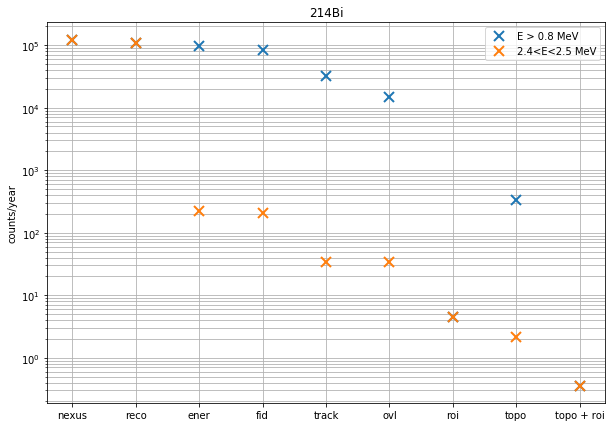

In [24]:
bi_sum_rates = compute_rates('214Bi', type='_spurious', act_version='_upd2')
plot_rates(bi_sum_rates.sum(), pd.DataFrame(), '214Bi', 'counts/year')

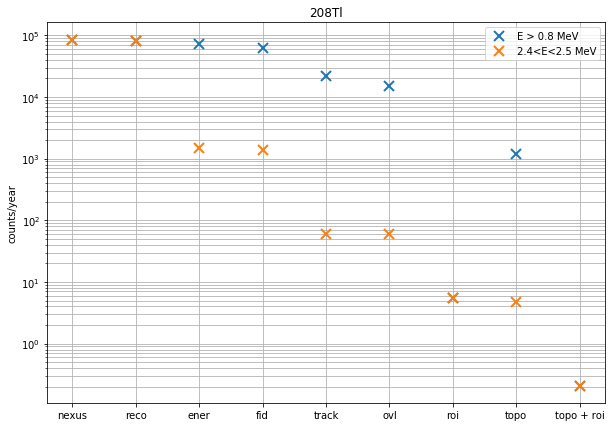

In [25]:
tl_sum_rates = compute_rates('208Tl', type='_spurious', act_version='_upd2')
plot_rates(tl_sum_rates.sum(), pd.DataFrame(), '208Tl', 'counts/year')

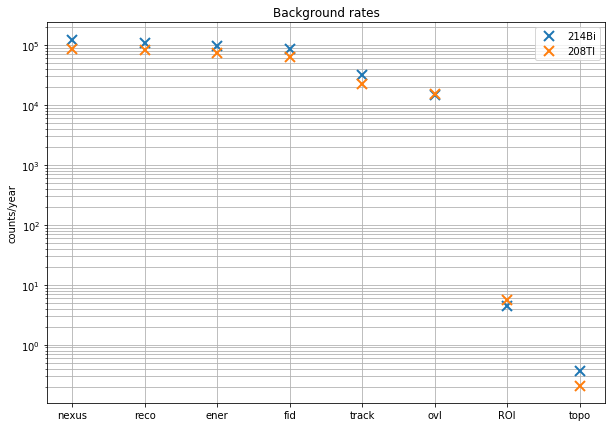

In [26]:
bi_sum_rates = compute_rates('214Bi', type='_spurious', act_version='_upd2')
tl_sum_rates = compute_rates('208Tl', type='_spurious', act_version='_upd2')

plot_rates_both(bi_sum_rates.sum(), tl_sum_rates.sum(), '214Bi', '208Tl', 'counts/year')

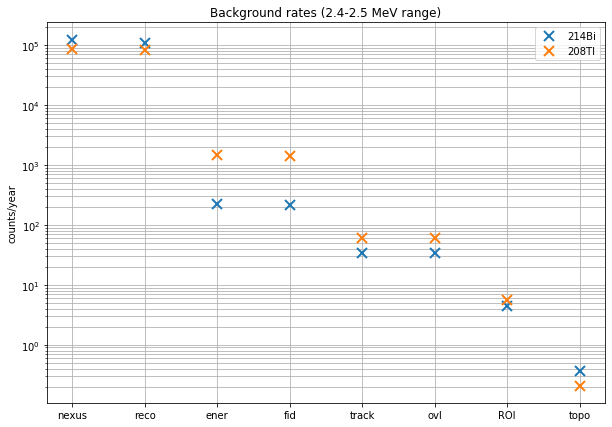

In [71]:
# bi_sum_rates = compute_rates('214Bi', type='_spurious', act_version='_upd2')
# tl_sum_rates = compute_rates('208Tl', type='_spurious', act_version='_upd2')

# plot_rates_both(bi_sum_rates.sum(), tl_sum_rates.sum(), '214Bi', '208Tl', 'counts/year')

In [27]:
bi_sum_rates['vol'] = read_act_and_sim('214Bi', act_version='_upd2').vol
tl_sum_rates['vol'] = read_act_and_sim('208Tl', act_version='_upd2').vol

plot_rates_df = bi_sum_rates[['vol', 'topo_roi_full']].set_index('vol').rename(columns = {'topo_roi_full':'214Bi'}).merge(\
    tl_sum_rates[['vol', 'topo_roi_full']].set_index('vol').rename(columns = {'topo_roi_full':'208Tl'}), on = 'vol')


In [28]:
plot_rates_df.sum()

214Bi    0.359635
208Tl    0.208927
dtype: float64

Text(0.5, 1.0, '')

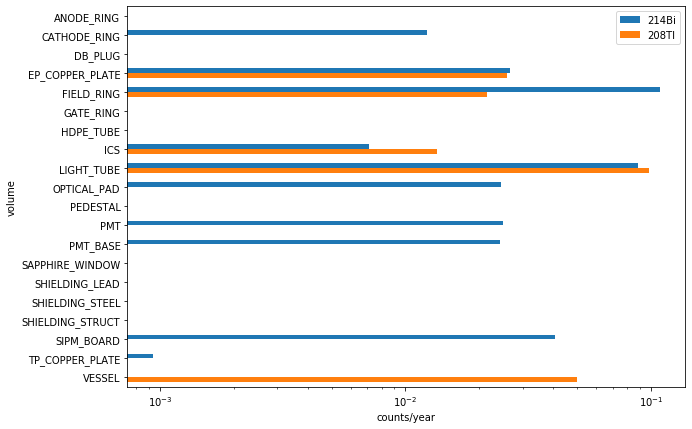

In [29]:
plot_rates_df.plot.barh(figsize=(10, 7))
#tl_sum_rates[['vol', 'topo_roi_full']].set_index('vol').plot.barh(figsize=(10, 7))
# bi_sum_rates.set_index('vol').topo_roi_full.plot.barh(figsize=(10, 7))
# tl_sum_rates.set_index('vol').topo_roi_full.plot.barh(figsize=(10, 7))
plt.gca().invert_yaxis()
plt.xscale('log')
plt.xlabel('counts/year')
plt.ylabel('volume')
plt.title('')

In [30]:
print('Total sim evs')
read_act_and_sim('214Bi', act_version='_upd2').sim.sum() + read_act_and_sim('208Tl', act_version='_upd2').sim.sum()

Total sim evs


16275995277

In [31]:
print('Total sim 214Bi', read_act_and_sim('214Bi', act_version='_upd2').sim.sum())
print('Total sim 208Tl', read_act_and_sim('208Tl', act_version='_upd2').sim.sum())

Total sim 214Bi 14108993103
Total sim 208Tl 2167002174


In [32]:
print('Total saved')
compute_rates('214Bi', type='_spurious', act_version='_upd2', rates_year = False).nexus.sum() + compute_rates('208Tl', type='_spurious', act_version='_upd2', rates_year = False).nexus.sum()

Total saved


11314534

In [33]:
print('Total saved 214Bi', compute_rates('214Bi', type='_spurious', act_version='_upd2', rates_year = False).nexus.sum())
print('Total saved 208Tl', compute_rates('208Tl', type='_spurious', act_version='_upd2', rates_year = False).nexus.sum())


Total saved 214Bi 5475916
Total saved 208Tl 5838618


In [34]:
print('Total ene 214Bi', compute_rates('214Bi', type='_spurious', act_version='_upd2', rates_year = False).ener.sum())
print('Total ene 208Tl', compute_rates('208Tl', type='_spurious', act_version='_upd2', rates_year = False).ener.sum())

Total ene 214Bi 4413486
Total ene 208Tl 5131420


Text(0.5, 1.0, '')

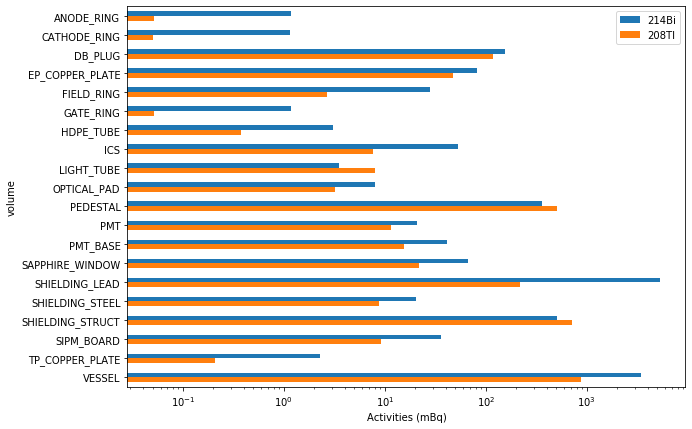

In [35]:
bi_act = read_act_and_sim('214Bi', act_version='_upd2')[['vol', 'activities']]
tl_act = read_act_and_sim('208Tl', act_version='_upd2')[['vol', 'activities']]

act = bi_act.rename(columns={'activities':'214Bi'}).merge(tl_act.rename(columns={'activities':'208Tl'}), on = 'vol').set_index('vol')

act.plot.barh(figsize=(10, 7))
plt.gca().invert_yaxis()
plt.xscale('log')
plt.xlabel('Activities (mBq)')
plt.ylabel('volume')
plt.title('')

Text(0.5, 1.0, 'Efficiencies for E > 0.8 MeV')

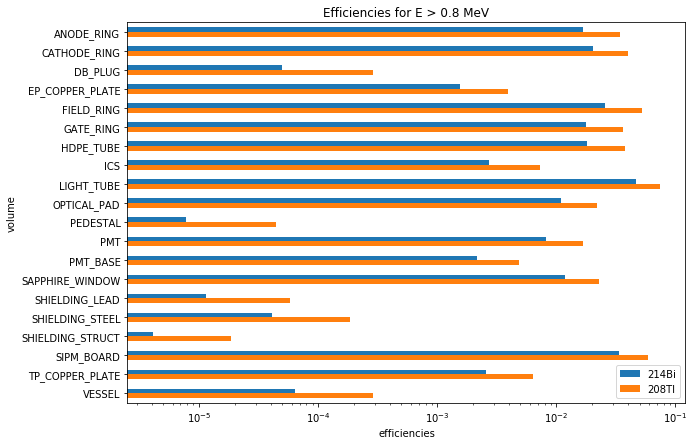

In [36]:
eff_counts = 'nexus'
bi_rates = compute_rates('214Bi', type='_spurious', act_version='_upd2', rates_year = False).reset_index(drop = True)[['vol', eff_counts]]
bi_sim   = read_act_and_sim('214Bi', act_version='_upd2')[['vol', 'sim']]
bi_rates[eff_counts] = bi_rates[eff_counts] / bi_sim['sim']
tl_rates = compute_rates('208Tl', type='_spurious', act_version='_upd2', rates_year = False).reset_index(drop = True)[['vol', eff_counts]]
tl_sim   = read_act_and_sim('208Tl', act_version='_upd2')[['vol', 'sim']]
tl_rates[eff_counts] = tl_rates[eff_counts] / tl_sim['sim']
eff = bi_rates.rename(columns={eff_counts:'214Bi'}).merge(tl_rates.rename(columns={eff_counts:'208Tl'}), on = 'vol').set_index('vol')
eff.plot.barh(figsize=(10, 7))
plt.gca().invert_yaxis()
plt.xscale('log')
plt.xlabel('efficiencies')
plt.ylabel('volume')
plt.title('Efficiencies for E > 0.8 MeV')


Text(0.5, 1.0, 'Efficiencies for [2.4, 2.5] MeV')

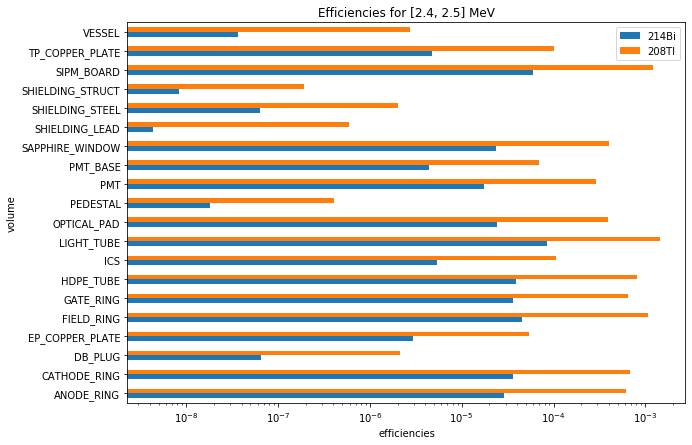

In [37]:
eff_counts = 'ener_roi'
bi_rates = compute_rates('214Bi', type='_spurious', act_version='_upd2', rates_year = False).reset_index(drop = True)[['vol', eff_counts]]
bi_sim   = read_act_and_sim('214Bi', act_version='_upd2')[['vol', 'sim']]
bi_rates[eff_counts] = bi_rates[eff_counts] / bi_sim['sim']
tl_rates = compute_rates('208Tl', type='_spurious', act_version='_upd2', rates_year = False).reset_index(drop = True)[['vol', eff_counts]]
tl_sim   = read_act_and_sim('208Tl', act_version='_upd2')[['vol', 'sim']]
tl_rates[eff_counts] = tl_rates[eff_counts] / tl_sim['sim']
eff = bi_rates.rename(columns={eff_counts:'214Bi'}).merge(tl_rates.rename(columns={eff_counts:'208Tl'}), on = 'vol').set_index('vol')
eff.plot.barh(figsize=(10, 7))
plt.xscale('log')
plt.xlabel('efficiencies')
plt.ylabel('volume')
plt.title('Efficiencies for [2.4, 2.5] MeV')

In [38]:
# bi_info['bi_eff'] = bi_info.event / bi_info.sim_red
# tl_info['tl_eff'] = tl_info.event / tl_info.sim_red

# eff = bi_info[['vol', 'bi_eff']].merge(tl_info[['vol', 'tl_eff']], on = 'vol', how = 'outer')


Eficiencia inferior para mi: VESSEL, TP_COPPER_PLATE, SIPM_BOARD, SHIELDING_STRUCT(Tl), SIELDING_STEEL (Tl), SHIELDING_LEAD (Bi), PMT_BASE, PMT (Bi), PEDESTAL (Bi), LIGHT_TUBE, ICS, HDPE_TUBE*, GATE_RING*, FIELD_RING, EP_COPPER_PLATE, DB_PLUG *, CATHODE_RING (Bi), ANODE_RING (BI)


Eficiencia superior para mi: SHIELDING_STRUCT(Bi), SHIELDING_STEEL (Bi), SHIELDING_LEAD(Tl), CATHODE_RING (Tl), ANODE_RING (Tl)


APPROX IGUAL: SAPPHIRE_WINDOW, PMT (Tl), PEDESTAL (Tl), OPTICAL_PAD

In [39]:
# eff.set_index('vol').plot.barh(figsize = (10, 7))
# plt.xscale('log')
# plt.grid(which = 'both')
# plt.xlim([7e-9, 7e-2])

In [40]:
# a = compute_rates('214Bi', type='', act_version='_upd2')
# print('214Bi, regular:  ', a[0].topo_roi_full, a[1].topo_roi_full)
# print('factor: :', 100/a[0].topo_roi_full)

# a = compute_rates('214Bi', type='_spurious', act_version='_upd2')
# print('214Bi, spurious: ', a[0].topo_roi_full, a[1].topo_roi_full)
# print('factor: :', 100/a[0].topo_roi_full)

# a = compute_rates('208Tl', type='', act_version='_upd2')
# print('208Tl, regular:  ', a[0].topo_roi_full, a[1].topo_roi_full)
# print('factor: :', 100/a[0].topo_roi_full)

# a = compute_rates('208Tl', type='_spurious', act_version='_upd2')
# print('208Tl, spurious: ', a[0].topo_roi_full, a[1].topo_roi_full)
# print('factor: :', 100/a[0].topo_roi_full)


THIS DATA WAS DONE USING Z AND R AVERAGE

- activities_efficiencies.ods: ACTIVITIES IN THE DB:
* 214Bi: 0.9928914164307043, factor: 100.7159477312081
* 208Tl: 1.4985395762944604, factor: 66.73163764368287

- activities_efficiencies_upd.ods: ACTIVITIES I USED (given by Gonzalo, but they are not the ones he used):
* 214Bi: 4.318686013168177, factor: 23.155191114864184
* 208Tl: 1.740239507954858, factor: 57.4633546376158

- activities_efficiencies_upd2.ods: NEW ACTIVITIES (november, updated):
* 214Bi: 0.6914339729321523, factor: 144.62696933437
* 208Tl: 0.0154786791884302, factor: 6460.499554428816


The ones Gonzalo used (from his thesis' image) are very close to the latter, but for the ICS have different numbers (and maybe for others, I have to check)




I RERUN THE ANALISYS WITH Z AND R MAX AND MIN, SO THE VALUES CHANGED. WITH THESE CHANGES, I ALSO CREATED A NEW FILE WITH SPURIOUS TRACKS REMOVED. IT RESULTED IN NOTHING AT THE END BECAUSE FINAL COUNTS REMAINED THE SAME (DIFFERENT TO THE PRIOR ANALYSIS WITH Z AND R AVERAGE...)

Veamos cuanto ocupa todo por un año. Como cogi una fracción ~10% para cada volumen (algo superior), su exposure tb se reduce a ese ~10% ya que exposure = n_evs_sim / act, y yo estoy cogiendo la fracción de esos eventos simulados. 

Como no tengo la misma fracción para cada volumen, la calculo más concretamente y la multiplico por la exposure para tener la exposure de ese % de eventos

Ahora tengo que ir por cada volumen dividiendo lo que pesa cada carpeta por la exposure reducida (SALVO NEXUS, QUE SERÍA LO QUE PESA POR LA FRACCIÓN PARTIDO POR LA EXPOS REDUCIDA O MÁS BIEN LO QUE PESA PARTIDO POR LA EXPOSURE NORMAL), y así tener lo que pesa la simulación en un año para cada ciudad, tipo de producción y volumen. Luego sumo por volúmenes y hago un gráfico

In [41]:
def create_size_df(isotope):
    storage_path = '/mnt/lustre/scratch/nlsas//home/usc/ie/mpm/NEXT100/data/full_prod/{}/prod/volumes/storage_info_2.txt'.format(isotope)

    with open(storage_path, 'r') as f:
        text = f.readlines()
        f.close()

    dct_list = []
    for t in text:
        sep = t.split('\t')
        mbs = int(sep[0].rstrip('M'))
        sub_sep = sep[1].split('/')
        if len(sub_sep) == 1:
            continue
        vol = sub_sep[1]
        
        if sub_sep[-2] != 'prod':
            continue

        if (sub_sep[-2] == 'prod') & (len(sub_sep) > 2):
            #prod = sub_sep[2]
            city = sub_sep[-1].split('\n')[0]
            # if prod.split('\n')[0] == city:
            #     prod = 'both'

        # if (sub_sep[1] == 'nexus'):
        #     city = sub_sep[1]
        #     prod = 'both'
        if np.isin(city, ['ref_prod', 'old_prod', '']):
            continue
        dct = {'vol':vol, 'city':city, 'mbs':mbs}
        dct_list.append(dct)
    return pd.DataFrame(dct_list)



In [42]:
def order_cities_df(df):
    order = ['nexus', 'detsim', 'hypathia', 'penthesilea', 'sophronia', 'esmeralda', 'beersheba', 'isaura']
    df['order'] = df.city.apply(lambda x: order.index(x))
    df = df.sort_values('order').drop('order', axis = 1)
    return df

In [43]:
def compute_sizes_df(isotope, sim_act, mbs_df):
    #sim_act = compute_reduced_exposure(sim_act, isotope)
    
    mbs_df = mbs_df.merge(sim_act[['vol', 'exposure', 'reduced_exp']], on = 'vol')

    mbs_df['mbs'] = mbs_df['mbs'].where(mbs_df.city != 'nexus', mbs_df['mbs'] / mbs_df['exposure'])
    mbs_df['mbs'] = mbs_df['mbs'].where(mbs_df.city == 'nexus', mbs_df['mbs'] / mbs_df['reduced_exp'])

    mbs_df = mbs_df.groupby(['city']).sum().drop(['exposure', 'reduced_exp'], axis = 1).reset_index()

    mbs_df = order_cities_df(mbs_df)

    # sizes_old = mbs_df[np.isin(mbs_df['prod'], ['both', 'old_prod'])].drop('prod', axis = 1).rename(columns = {'mbs':isotope})
    # sizes_old.city = sizes_old.city.where(sizes_old.city != 'penthesilea', 'pen/sop')
    # sizes_ref = mbs_df[np.isin(mbs_df['prod'], ['both', 'ref_prod'])].drop('prod', axis = 1).rename(columns = {'mbs':'{} (ref)'.format(isotope)})
    # sizes_ref.city = sizes_ref.city.where(sizes_ref.city != 'sophronia', 'pen/sop')
    # total_sizes = sizes_old.merge(sizes_ref, on = 'city')
    mbs_df[mbs_df.select_dtypes("number").columns] /= 1024
    mbs_df = mbs_df.rename(columns={'mbs':isotope})
    ### OUTPUT SIZES IN GB
    return mbs_df

In [44]:
isotopes = ['214Bi', '208Tl']

df = []
for isotope in isotopes:
    sim_act = read_act_and_sim(isotope)
    mbs_df = create_size_df(isotope)
    total_sizes = compute_sizes_df(isotope, sim_act, mbs_df)
    df.append(total_sizes)
    

In [45]:
bi_size = order_cities_df(create_size_df('214Bi').groupby('city').sum().reset_index())
bi_size[bi_size.select_dtypes("number").columns] /= 1024
bi_size = bi_size.rename(columns={'mbs':'214Bi'})

tl_size = order_cities_df(create_size_df('208Tl').groupby('city').sum().reset_index())
tl_size[tl_size.select_dtypes("number").columns] /= 1024
tl_size = tl_size.rename(columns={'mbs':'208Tl'})


total_sizes = bi_size.merge(tl_size, on = 'city')

Text(0.5, 0, 'G')

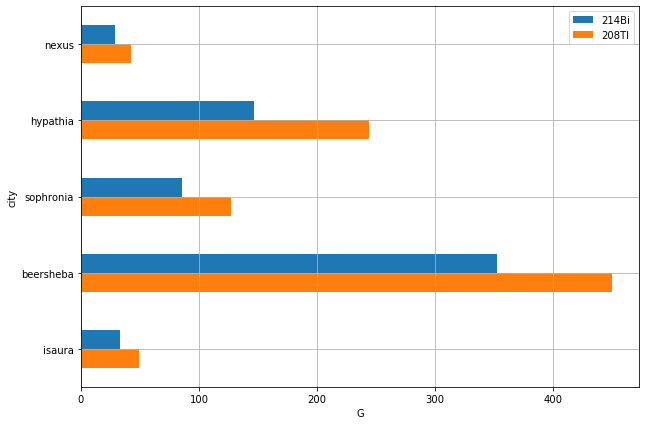

In [46]:
total_sizes.set_index('city').plot.barh(figsize=(10, 7))
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('G')

In [47]:
create_size_df('214Bi').mbs.sum() / 1024 / 1024

0.6728601455688477

In [48]:
create_size_df('208Tl').mbs.sum() / 1024 / 1024

0.8928461074829102

In [49]:
0.6728601455688477 + 0.8928461074829102

1.5657062530517578

In [50]:
final_total_sizes = df[0].merge(df[1], on = 'city')

In [51]:
final_total_sizes

,city,214Bi,208Tl
0,nexus,0.728209,2.136596
1,hypathia,3.650859,12.203572
2,sophronia,2.137489,6.371392
3,beersheba,8.771292,22.509649
4,isaura,0.831734,2.444367


In [52]:
final_total_sizes.drop('city', axis = 1).sum() /1024

214Bi    0.015742
208Tl    0.044595
dtype: float64

A ver, hay volumenes q con muy poca exposure dan muchisimos eventos, y volumenes q con mucha exposure dan pocos eventos. Por ejemplo para el Bi, tenemos que en ICS, Field ring y copper plate muy poca exposicion dan muchos eventos y aumentarla hace q se desorbiten los tamaños de ficheros etc

MIRAR q almacenamiento nos haría falta para cada isotopo con el factor que queremos y eso

In [53]:
final_total_sizes['208Tl'].sum() / 1024 #* tl_factor /1024

0.04459528879659216

In [54]:
final_total_sizes['214Bi'].sum() / 1024

0.015741780406322178

Text(0.5, 0, 'G/year')

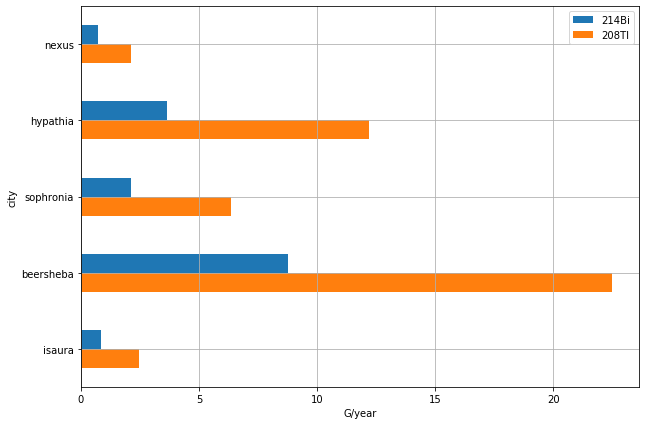

In [55]:
final_total_sizes.set_index('city').plot.barh(figsize=(10, 7))
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('G/year')

In [52]:
idx = ['nexus', 'detsim', 'hypathia', 'pen/sop', 'esmeralda', 'beersheba', 'isaura']
tl_old = [90, 74, 25, 12, 18, 37, 5]
tl_ref = [90, 74, 25, 13, 6.5, 37, 5]

bi_old = [47, 58, 15, 7.7, 13, 31, 3.5]
bi_ref = [47, 58, 15, 8.8, 4.5, 30, 3.5]

diskspace = pd.DataFrame(np.array([tl_old, tl_ref, bi_old, bi_ref]).T, index = idx).rename(columns = {0:'208Tl', 1:'208Tl (ref)', 2:'214Bi', 3:'214Bi (ref)'})

Text(0.5, 0, 'GB')

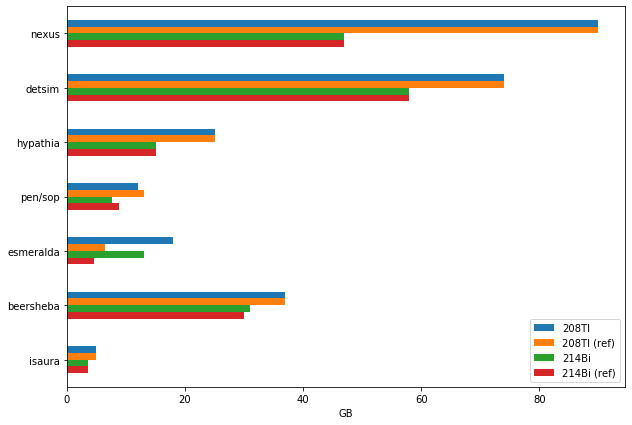

In [ ]:
diskspace.plot.barh(figsize=(10, 7))

plt.gca().invert_yaxis()
plt.xlabel('GB')

In [6]:
def get_ener_spectra(isotope, nbins, xrange, density = False, type = ''):
    ener_paths = glob('/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/full_prod/{}/prod/volumes/*/events_energy{}.h5'.format(isotope, type))
    ener_df = pd.DataFrame([])
    hist = []
    if type == '': ev_id, group = 'event_id', 'MC'
    else: ev_id, group = 'event', 'RECO'
    
    for p in ener_paths:
        eners = dio.load_dst(p, group, 'EventEnergy')
        eners = eners[(eners.energy > 0.8)] 
        ener_df = ener_df.append(eners)
        hist.append(np.histogram(eners.energy,bins = nbins, range=xrange, density=density)[0])
    return ener_df, hist

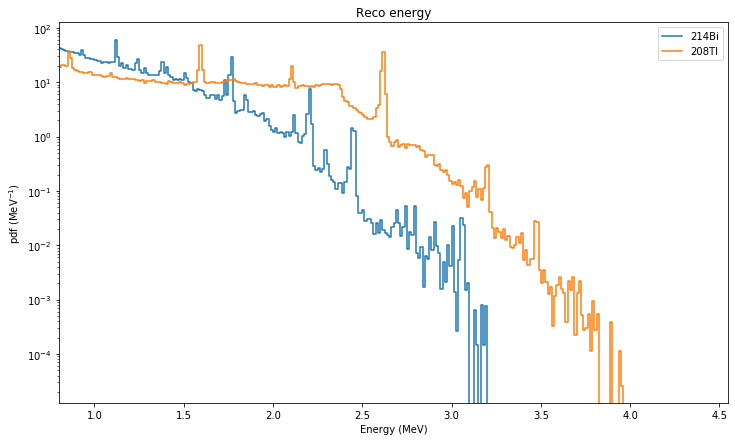

In [7]:
nbins = 300
xrange = (0.8, 4.55)

edges = np.linspace(xrange[0], xrange[1], nbins + 1)
bincentres = [(edges[i]+edges[i+1])/2. for i in range(len(edges)-1)]

ener_bi, hist_bi = get_ener_spectra('214Bi', nbins, xrange, density = True, type = '_reco')
ener_tl, hist_tl = get_ener_spectra('208Tl', nbins, xrange, density = True, type = '_reco')

plt.figure(figsize=(12, 7))
plt.step(bincentres, sum(hist_bi), where = 'mid', label = '214Bi')
plt.step(bincentres, sum(hist_tl), where = 'mid', label = '208Tl')


plt.yscale('log')
plt.xlabel('Energy (MeV)')
plt.ylabel(r'pdf (MeV$^{-1}$)')
plt.title('Reco energy')
plt.xlim(xrange)
plt.legend()

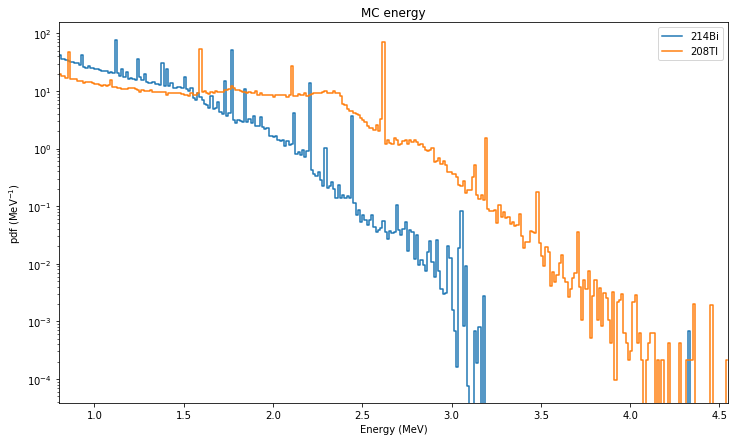

In [99]:
nbins = 300
xrange = (0.8, 4.55)

edges = np.linspace(xrange[0], xrange[1], nbins + 1)
bincentres = [(edges[i]+edges[i+1])/2. for i in range(len(edges)-1)]


ener_bi, hist_bi = get_ener_spectra('214Bi', nbins, xrange, density = True)
ener_tl, hist_tl = get_ener_spectra('208Tl', nbins, xrange, density = True)


plt.figure(figsize=(12, 7))
plt.step(bincentres, sum(hist_bi), where = 'mid', label = '214Bi')
plt.step(bincentres, sum(hist_tl), where = 'mid', label = '208Tl')


plt.yscale('log')
plt.xlabel('Energy (MeV)')
plt.ylabel(r'pdf (MeV$^{-1}$)')
plt.title('MC energy')
plt.xlim(xrange)
plt.legend()